In [305]:
import pandas as pd
import scipy as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import warnings
import matplotlib.dates as mdates

plt.style.use('seaborn')

from sklearn import linear_model

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

%matplotlib inline

In [298]:
def get_csvs_paths(dataset_dir):
    result = {}
    for d, dirs, files in os.walk(dataset_dir):
        for name in files:
            if '.swp' in name:
                continue
            result[name] = dataset_dir + '/' + name
    
    return result

In [299]:
def extract_dataset(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    instances = pd.unique(df['instance'])
    
    return df, instances

def extract_csv(csv_path):
    df = pd.read_csv(csv_path)
    df['time'] = '2018_' + df['time']
    df['time'] = pd.to_datetime(df['time'], format='%Y_%d_%m_%H:%M')
    
    return df

write_reqs_df, instances = extract_dataset('final/train_us3/abgw_write_reqs_total.csv')
read_reqs_df, instances = extract_dataset('final/train_us3/abgw_read_reqs_total.csv')
latency_df, instances = extract_dataset('final/train_us3/abgw_iop_latency_ms_sum.csv')
latency_count_df, instances = extract_dataset('final/train_us3/abgw_iop_latency_ms_count.csv')
dtf_df, instances = extract_dataset('final/train_us3/abgw_detached_files_rate.csv')
dtf, instances = extract_dataset('final/train_us3/abgw_detached_files.csv')

In [4]:
write_node_0 = write_reqs_df[write_reqs_df['instance'] == instances[10]]
read_node_0 = read_reqs_df[read_reqs_df['instance'] == instances[10]]
latency_0 = latency_df[latency_df['instance'] == instances[10]]
latency_count_0 = latency_count_df[latency_count_df['instance'] == instances[10]]
dtf_0 = dtf_df[dtf_df['instance'] == instances[10]]
dttf = dtf[dtf['instance'] == instances[10]]

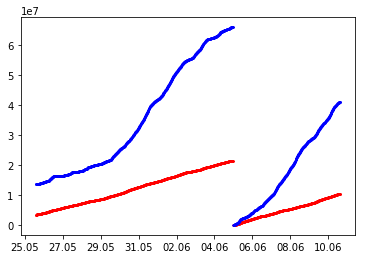

In [5]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d.%m"))
ax.plot(write_node_0['time'], write_node_0['abgw_write_reqs_total'], 'ro', markersize=1)
ax.plot(read_node_0['time'], read_node_0['abgw_read_reqs_total'], 'bo', markersize=1)
plt.show()

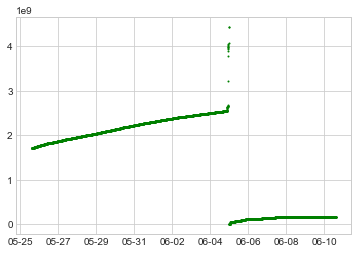

In [300]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(latency_0['time'], latency_0['abgw_iop_latency_ms_sum'], 'go', markersize=1)

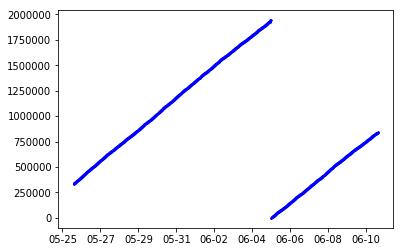

In [7]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(latency_count_0['time'], latency_count_0['abgw_iop_latency_ms_count'], 'bo', markersize=1)

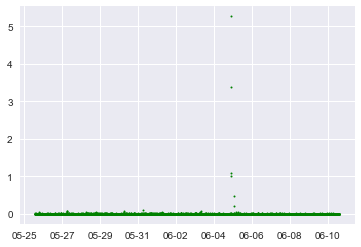

In [307]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(dtf_0['time'], dtf_0['abgw_detached_files_rate'], 'go', markersize=2)

In [9]:
req_df = pd.DataFrame()
req_df['read'] = read_node_0['abgw_read_reqs_total']
req_df['write'] = write_node_0['abgw_write_reqs_total']
req_df.head()

,read,write
120,13614429,3414294
121,13625425,3418527
122,13627455,3421827
123,13632961,3425327
124,13638357,3429410


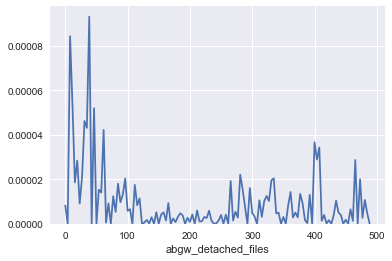

In [308]:
sns.distplot(dtf['abgw_detached_files'], hist=False)

In [13]:
req_df['total'] = req_df['read'] + req_df['write']
req_df['time'] = write_node_0['time']
req_df['latency'] = latency_0['abgw_iop_latency_ms_sum']
req_df['latency_count'] = latency_count_0['abgw_iop_latency_ms_count']
req_df['dtf_rate'] = dtf_0['abgw_detached_files_rate']
req_df['dtf'] = dtf['abgw_detached_files']
req_df[['write', 'read', 'latency', 'latency_count', 'dtf_rate', 'dtf']].corr()

,write,read,latency,latency_count,dtf_rate,dtf
write,1.000000,0.972827,0.998749,0.998198,0.052968,0.101255
read,0.972827,1.000000,0.977249,0.978234,0.052523,0.099311
latency,0.998749,0.977249,1.000000,0.999733,-0.219037,-0.124259
latency_count,0.998198,0.978234,0.999733,1.000000,-0.221585,-0.126660
dtf_rate,0.052968,0.052523,-0.219037,-0.221585,1.000000,0.469147
dtf,0.101255,0.099311,-0.124259,-0.126660,0.469147,1.000000


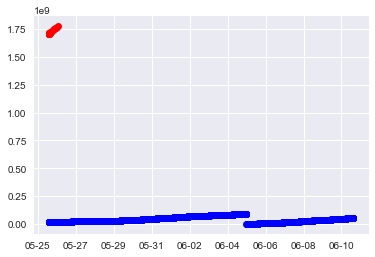

In [309]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
ax.plot(req_df['time'], req_df['total'], 'bo')
ax.plot(req_df['time'], req_df['latency'], 'ro')
plt.show()

In [15]:
total_df = pd.merge(write_reqs_df, read_reqs_df, on=['time', 'instance'])
total_df = pd.merge(total_df, latency_df, on=['time', 'instance'])
total_df = pd.merge(total_df, latency_count_df, on=['time', 'instance'])
total_df = pd.merge(total_df, dtf_df, on=['time', 'instance'])
total_cols = ['time', 'abgw_read_reqs_total', 'abgw_write_reqs_total', 'abgw_iop_latency_ms_sum',
              'abgw_iop_latency_ms_count', 'abgw_detached_files_rate', 'instance']
total_df = total_df[total_cols]

In [188]:
total = pd.DataFrame()
for name, path in get_csvs_paths('final/train_us3').items():
    df = extract_csv(path)
    if len(total.columns) == 0:
        print('new df - %s' % (name))
        total = df
    else:
        print('merging - %s' % (name))
        total = pd.merge(total, df, on=['time', 'instance'])

total_cols = [
    'time',
    'abgw_write_reqs_total',
    'abgw_read_reqs_total',
    'abgw_stat_reqs_total',
    'abgw_req_errs_total',
    'abgw_iop_latency_ms_count',
    'abgw_detached_files_rate',
    'abgw_detached_files',
    'abgw_fds',
    'abgw_io_limiting_failures_total',
    'abgw_iop_latency_ms_rate',
    'abgw_iop_latency_ms_sum',
    'abgw_write_rollback_bytes_total',
    'abgw_write_rollback_bytes_rate',
    'abgw_req_errs_rate',
    'abgw_account_lookup_errs_total',
    'instance',
]

total.rename(columns=lambda c: c.replace('abgw_', ''), inplace=True)

new df - abgw_write_rollback_bytes_total.csv
merging - abgw_account_lookup_errs_rate.csv
merging - abgw_file_lookup_errs_rate.csv
merging - abgw_write_reqs_total.csv
merging - abgw_iop_latency_ms_count.csv
merging - abgw_iop_latency_ms_sum.csv
merging - abgw_account_pull_errs_rate.csv
merging - abgw_account_pull_errs_total.csv
merging - abgw_account_lookup_errs_total.csv
merging - abgw_detached_files_rate.csv
merging - abgw_write_rollback_bytes_rate.csv
merging - abgw_req_errs_total.csv
merging - abgw_detached_files.csv
merging - abgw_stat_reqs_total.csv
merging - abgw_fds.csv
merging - abgw_io_limiting_failures_total.csv
merging - abgw_iop_latency_ms_rate.csv
merging - abgw_io_limiting_failures_rate.csv
merging - abgw_req_errs_rate.csv
merging - abgw_read_reqs_total.csv


In [189]:
total.drop(['account_pull_errs_rate', 'account_pull_errs_total'], inplace=True, axis=1)
total.columns

Index([u'time', u'write_rollback_bytes_total', u'instance',
       u'account_lookup_errs_rate', u'file_lookup_errs_rate',
       u'write_reqs_total', u'iop_latency_ms_count', u'iop_latency_ms_sum',
       u'account_lookup_errs_total', u'detached_files_rate',
       u'write_rollback_bytes_rate', u'req_errs_total', u'detached_files',
       u'stat_reqs_total', u'fds', u'io_limiting_failures_total',
       u'iop_latency_ms_rate', u'io_limiting_failures_rate', u'req_errs_rate',
       u'read_reqs_total'],
      dtype='object')

In [190]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92793 entries, 0 to 92792
Data columns (total 20 columns):
time                          92793 non-null datetime64[ns]
write_rollback_bytes_total    92793 non-null int64
instance                      92793 non-null object
account_lookup_errs_rate      92793 non-null float64
file_lookup_errs_rate         92793 non-null float64
write_reqs_total              92793 non-null int64
iop_latency_ms_count          92793 non-null int64
iop_latency_ms_sum            92793 non-null float64
account_lookup_errs_total     92793 non-null int64
detached_files_rate           92793 non-null float64
write_rollback_bytes_rate     92793 non-null float64
req_errs_total                92793 non-null int64
detached_files                92793 non-null int64
stat_reqs_total               92793 non-null int64
fds                           92793 non-null int64
io_limiting_failures_total    92793 non-null int64
iop_latency_ms_rate           92793 non-null float64
io

In [185]:
instances = pd.unique(total['instance'])
print('amount of instances %d' %(len(instances)))

amount of instances 24


In [191]:
example_node = total[total['instance'] == instances[0]]
example_node = example_node.drop(['time', 'instance'], axis=1)

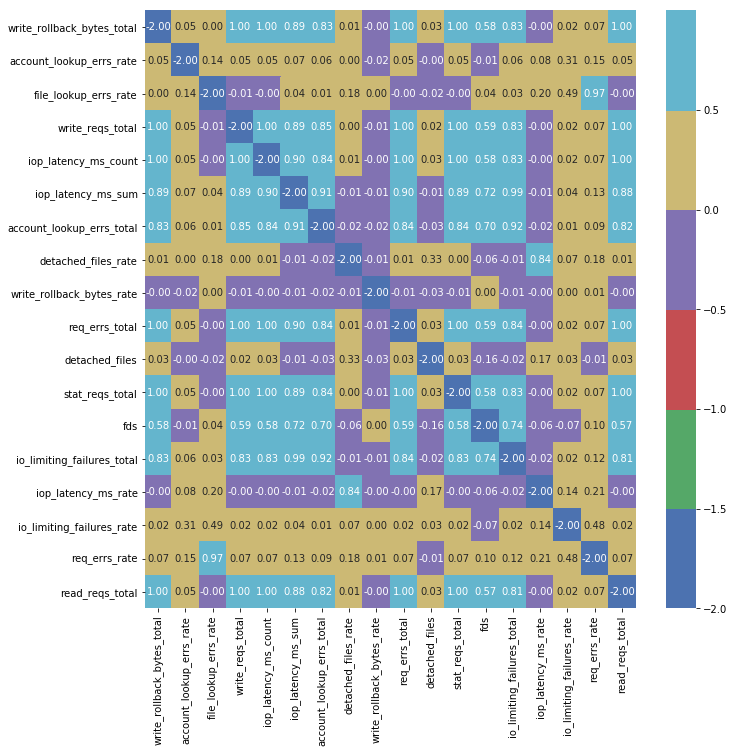

In [192]:
corrs = example_node.corr()
np.fill_diagonal(corrs.values, -2)
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(corrs, annot=True, fmt=".2f", cmap=sns.color_palette("deep"), ax=ax)

In [180]:
pd.unique(example_node['account_pull_errs_rate'])

array([0.])

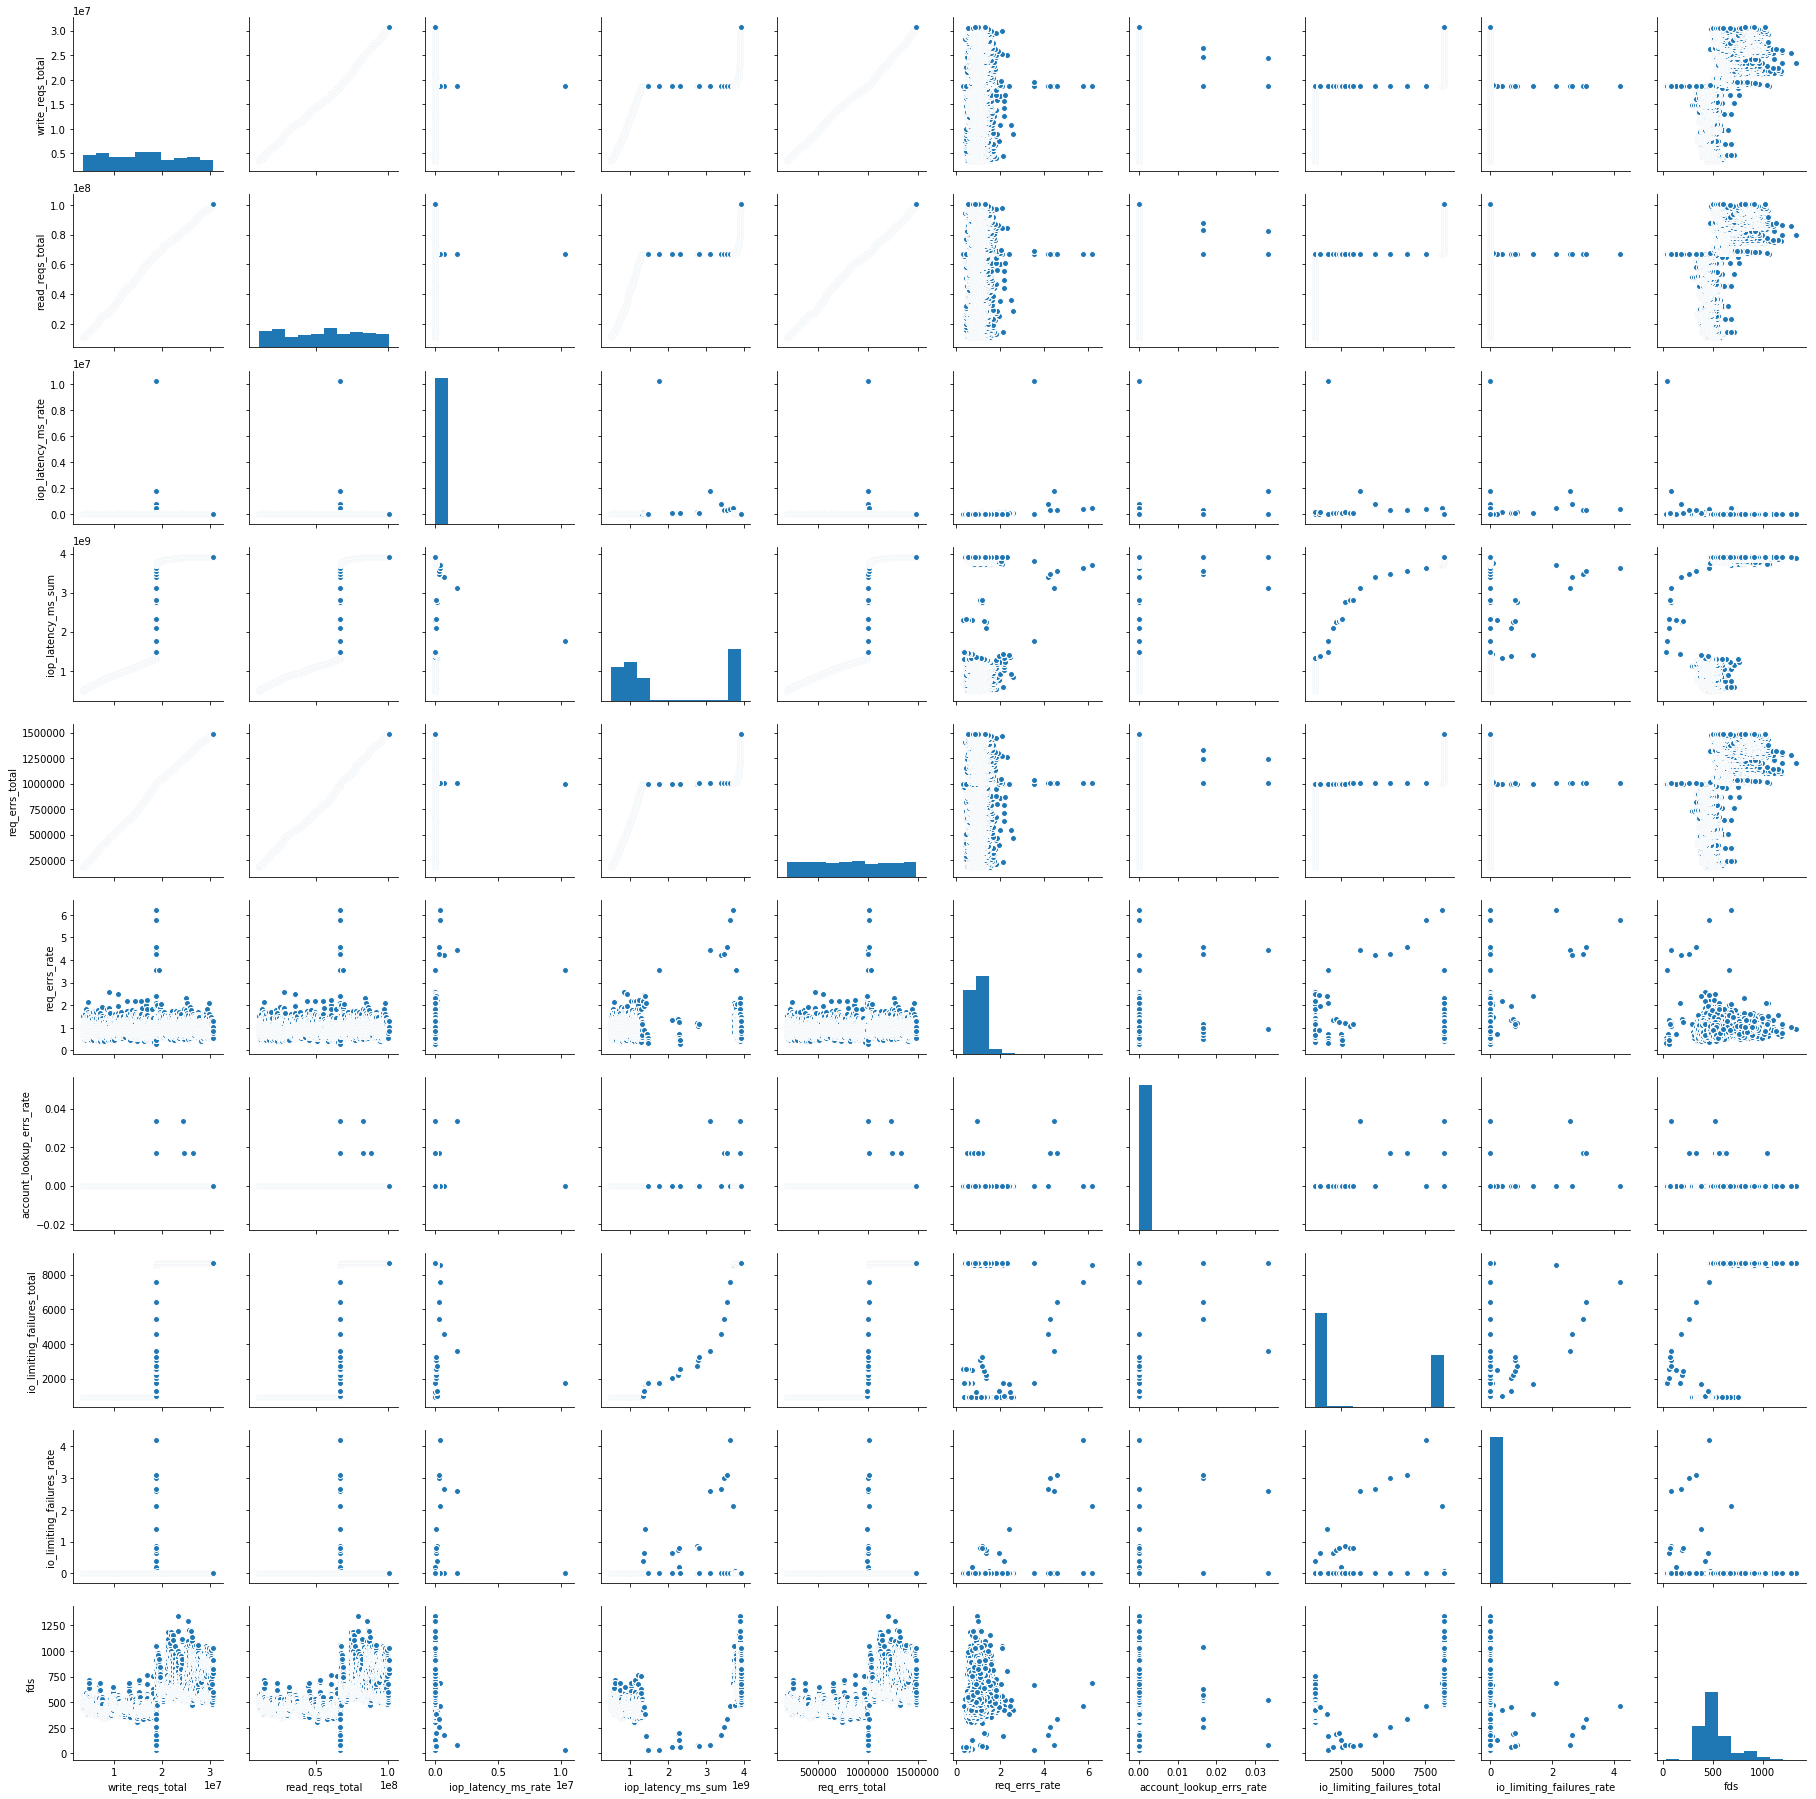

In [157]:
key_cols = ['write_reqs_total',
            'read_reqs_total',
            'iop_latency_ms_rate',
            'iop_latency_ms_sum',
            'req_errs_total',
            'req_errs_rate',
            'account_lookup_errs_rate',
            'io_limiting_failures_total',
            'io_limiting_failures_rate',
            'fds']
sns.pairplot(example_node[key_cols])

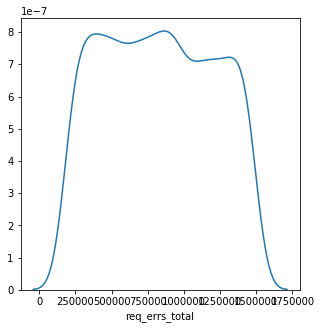

In [195]:
plt.rcParams['figure.figsize']=(5, 5)
sns.distplot(example_node['req_errs_total'], hist=False)

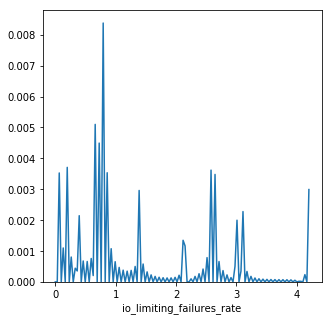

In [159]:
sns.distplot(example_node['io_limiting_failures_rate'], hist=False)

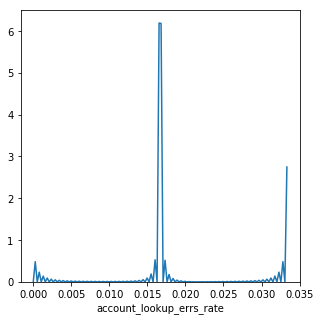

In [196]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

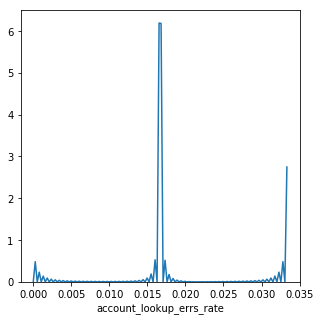

In [149]:
sns.distplot(example_node['account_lookup_errs_rate'], hist=False)

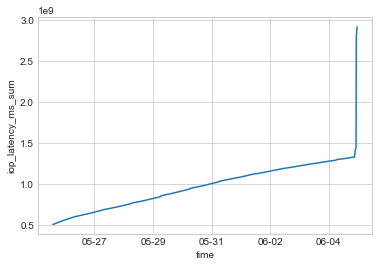

In [301]:
example_node = total[total['instance'] == instances[11]]
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
plt.plot(example_node['time'], example_node['iop_latency_ms_sum'])
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

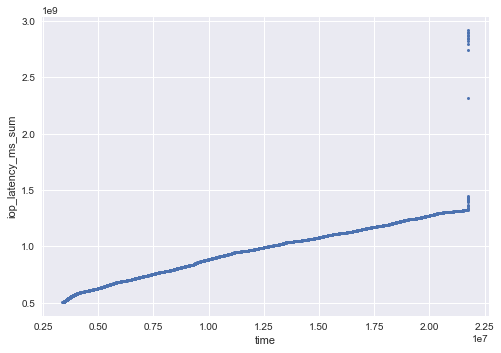

In [313]:
plt.style.use('seaborn')
plt.plot(example_node['write_reqs_total'], example_node['iop_latency_ms_sum'], linestyle='none', marker='o',
         markersize=3)
plt.xlabel('time')
plt.ylabel('iop_latency_ms_sum')
plt.show()

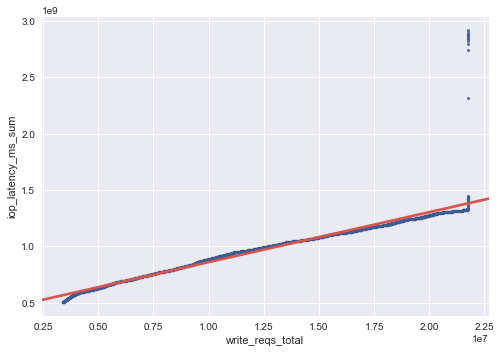

In [336]:
sns.regplot(x='write_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

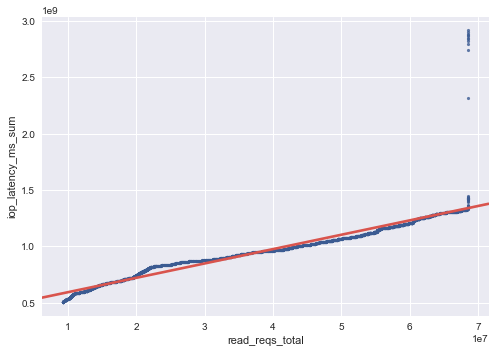

In [337]:
sns.regplot(x='read_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s": 10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

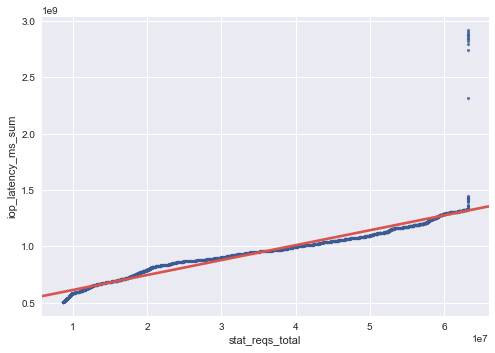

In [338]:
sns.regplot(x='stat_reqs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

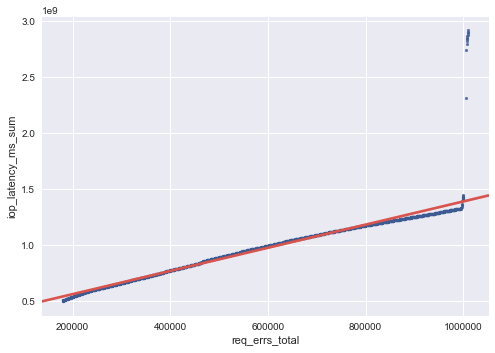

In [339]:
sns.regplot(x='req_errs_total', y='iop_latency_ms_sum', data=example_node,
            scatter_kws={"color": sns.xkcd_rgb["denim blue"], "s":10}, line_kws={"color": sns.xkcd_rgb["pale red"]})

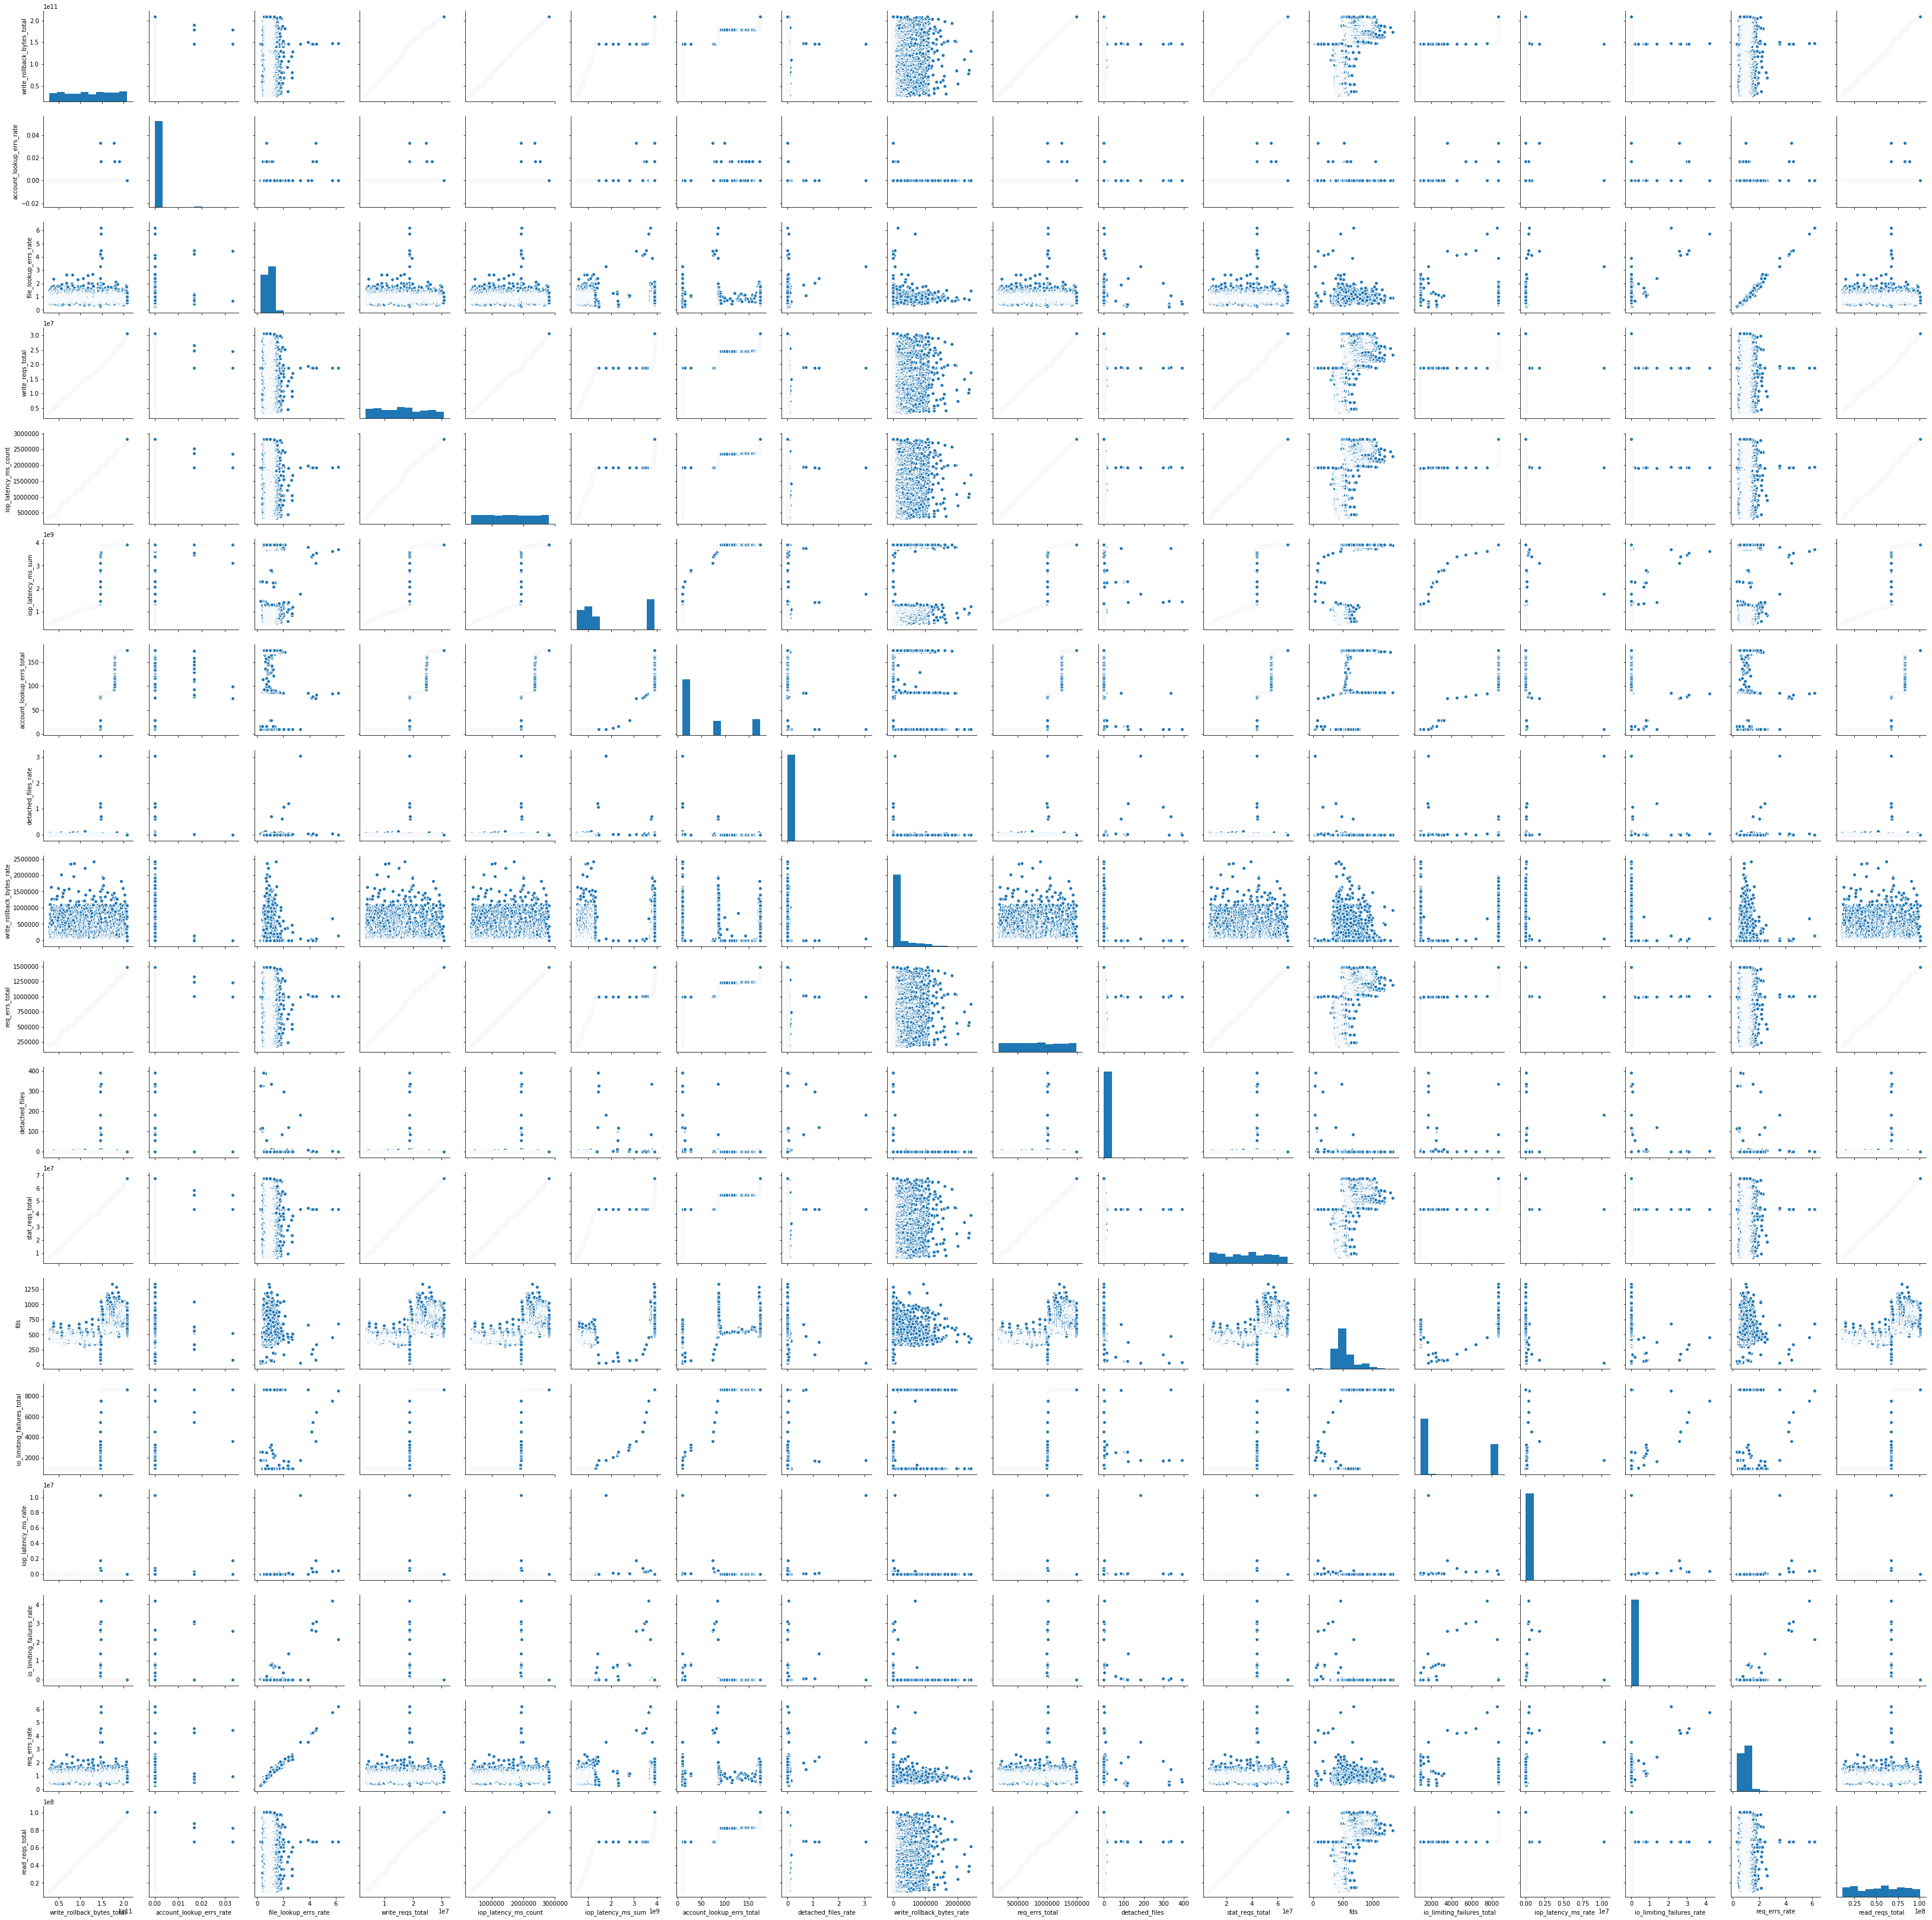

In [213]:
sns.pairplot(example_node)

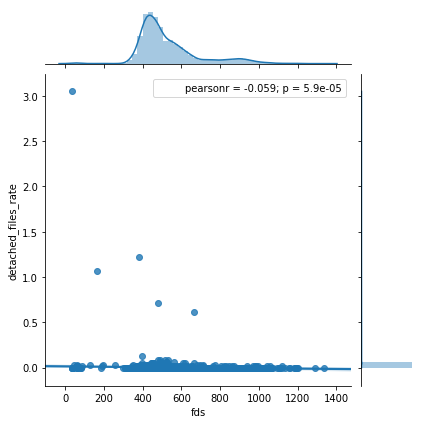

In [212]:
sns.jointplot(y='detached_files_rate', x='fds', data=example_node, kind='reg')

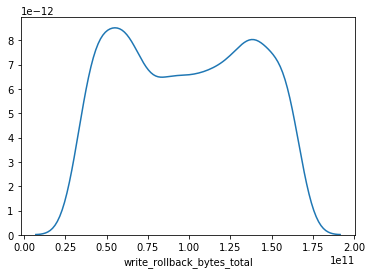

In [81]:
sns.distplot(example_node['write_rollback_bytes_total'], hist=False)